In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import graph_tool.all as gt

from pyvis.network import Network
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from IPython.core.display import display
from IPython.display import IFrame

In [2]:
sns.set()

## Data Preparation

In [3]:
from scipy.io import loadmat

In [4]:
data_path = "/usr/people/runzhey/seungmount/research/runzhey/FlyModularity/saved/MatOrder_CO_top500_2blocks_06122020.mat"
lou_cellid = loadmat(data_path) 
data_path = "/usr/people/runzhey/seungmount/research/runzhey/FlyModularity/saved/cellIDType_CO_top500_2blocks_06122020.mat"
lou_celltypes = loadmat(data_path) 

In [5]:
lou_cellid = lou_cellid['MatOrder_CO_top500_2blocks_06122020']
lou_celltypes = lou_celltypes['cellIDType_CO_top500_2blocks_06122020']

In [6]:
lou_dict = dict(zip(lou_cellid[0], lou_celltypes))

In [247]:
np.unique(lou_celltypes, return_counts=True)

(array(['ABD_i', 'ABD_m', '_Axl_', '_DOs_', '_Int_', 'vSPNs'], dtype='<U5'),
 array([ 22,  32, 266,  34, 240,   5]))

In [9]:
import pickle
with open('saved/finalgraph_SBM_Zfish_eig.data', 'rb') as input:    
    u_SBM = pickle.load(input)    
with open('saved/finalgraph_spectral_Zfish_eig.data', 'rb') as input:    
    u_spec = pickle.load(input)    

In [10]:
u_SBM

<Graph object, directed, with 2817 vertices and 44311 edges, 5 internal vertex properties, 1 internal edge property, at 0x7fbbb32d3a20>

In [11]:
u_spec

<Graph object, directed, with 2817 vertices and 44311 edges, 6 internal vertex properties, 1 internal edge property, at 0x7fbbb32f1e80>

In [12]:
u_louvian = gt.Graph(u_spec)

In [13]:
vw = u_louvian.new_vertex_property("int32_t")
for i, v in enumerate(u_louvian.vertices()):
    cid = u_louvian.vp["cellid"][v]
    if cid in lou_cellid[0]:
        if lou_dict[cid] in ['_Int_', '_DOs_']:
            vw[v] = 0
        elif lou_dict[cid] in ['_Axl_']:
            vw[v] = 1
        elif lou_dict[cid] in ['ABD_i', 'ABD_m']:
            vw[v] = 2
        elif lou_dict[cid] in ['vSPNs']:
            vw[v] = 3
    else:
        vw[v] = -1
u_louvian.vp['Louvain+ABD+vSPNs'] = vw

In [14]:
lcenter_filter_mask = np.isin(u_louvian.vp['Louvain+ABD+vSPNs'].a, [0,1])

lcenter_type_filter = u_louvian.new_vertex_property("bool")
for i, v in enumerate(u_louvian.vertices()):
    lcenter_type_filter[v] = u_louvian.vp['cellselected'][v] and lcenter_filter_mask[i]
lcenter_type_filter_mask = np.array(lcenter_type_filter.a, dtype=bool)

In [15]:
center_filter = u_spec.new_vertex_property("bool")
center_filter.a = (u_spec.get_in_degrees(u_spec.get_vertices()) * u_spec.get_out_degrees(u_spec.get_vertices()) > 0)
center_filter_mask = np.array(center_filter.a, dtype=bool) 

center_type_filter = u_spec.new_vertex_property("bool")
for i, v in enumerate(u_spec.vertices()):
    center_type_filter[v] = u_spec.vp['cellselected'][v] and center_filter[v]
center_type_filter_mask = np.array(center_type_filter.a, dtype=bool)

In [16]:
abd_filter_mask = np.array(u_spec.vp["celltype"].a)>=14
spn_filter_mask = np.isin(np.array(u_spec.vp["cellid"].a), [76202,77267,77268,76562,77931])

## Confusion and Connectivity Matrices of Louvain Clusters

In [17]:
u = u_louvian

In [18]:
typenames = ['Saccadic_M', 'Saccadic_I', 'IBN', 'IBNmirrorPop', 'RS', 'Vestibular_DO', 'Vestibular_MO', 'Vestibular_TO', 'Integrator_r456I', 'Integrator_r456M', 'Integrator_r456MI', 'Integrator_r56M', 'Integrator_r78ipis', 'Integrator_r78contra', 'Abducens_M', 'Abducens_I']

In [19]:
dic_lou2Type = np.array([u.vp["Louvain+ABD+vSPNs"].a[lcenter_type_filter_mask].tolist(), u.vp["celltype"].a[lcenter_type_filter_mask].tolist()]).T

In [20]:
typeM = np.zeros((2, 16))
for i in range(2):
    print("---")
    print("louvain type: {}".format(i))
    ids, cnts = np.unique(dic_lou2Type[dic_lou2Type[:,0]==i][:,1], return_counts=True)
    for cnt, nid, name in zip(cnts, ids, np.array(typenames)[ids].tolist()):
        typeM[i, nid] = cnt
        print(str(cnt)+" x "+str(name))

---
louvain type: 0
1 x IBN
34 x Vestibular_DO
47 x Integrator_r456I
14 x Integrator_r456M
27 x Integrator_r456MI
9 x Integrator_r56M
39 x Integrator_r78ipis
---
louvain type: 1
1 x IBN
9 x RS
1 x Integrator_r456I
4 x Integrator_r456M
8 x Integrator_r456MI


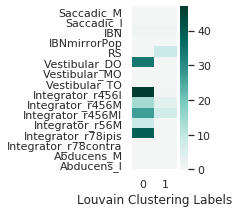

In [21]:
fig, ax = plt.subplots(figsize=(1,3))
# plt.axis('off')
sns.heatmap(typeM.T, center=0, 
            xticklabels=np.arange(2),
            yticklabels=typenames,
            cmap="BrBG", ax=ax)
plt.xlabel("Louvain Clustering Labels")
plt.show()

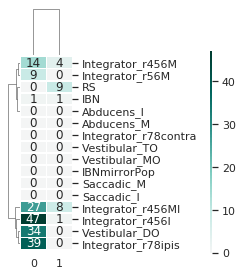

In [22]:
# plt.axis('off')
type_grid = sns.clustermap(typeM.T, 
               center=0, 
            xticklabels=np.arange(2),
            yticklabels=typenames,
            figsize=(3,4),
            row_cluster=True,
            col_cluster=True,
            annot=True,
            cmap="BrBG",
            linewidths=.5,
            cbar_pos=(1,0.1,0.01,0.7))
# plt.xlabel("nSBM Level 0 Labels")
plt.show()

In [23]:
plot_filter_mask = abd_filter_mask + lcenter_filter_mask + spn_filter_mask

In [24]:
plot_filter_mask.sum()

595

In [25]:
sepline = lambda x: np.cumsum(np.unique(x, return_counts=True)[1])

In [26]:
manual_group = ["0", "1", "ABD", "vSPNs"]

uol = u.vp["Louvain+ABD+vSPNs"].a[plot_filter_mask]
celltype_lou = [""]*len(uol)
for i, v in enumerate(uol):
    celltype_lou[i] = manual_group[v]

In [27]:
def pretty_print_label(labels):
    lbs = labels.copy().tolist()
    prev = -1
    start_i = 0
    for i, a in enumerate(lbs):
        if manual_group[a] == manual_group[prev]:
            lbs[i] = ""
        elif i == 0:
            lbs[i] = ""
            prev = a
            start_i = i
        else:
            pos = (start_i + i) // 2
            lbs[i] = ""
            lbs[pos] = manual_group[prev]
            prev = a
            start_i = i
    pos = (start_i + i) // 2
    lbs[pos] = manual_group[prev]
    return lbs

In [28]:
degree_seq = u.get_in_degrees(u.get_vertices())*u.get_out_degrees(u.get_vertices())
degree_seq = degree_seq[plot_filter_mask]

In [29]:
# ind_spec_type = np.argsort(celltype_spec)
ind_lou_type = np.lexsort((degree_seq, celltype_lou))

In [30]:
sep_lou_type = sepline(celltype_lou)

In [31]:
u_adj_full = gt.adjacency(u, weight=u.ep["#synapses"])

In [32]:
u_adj_sub = u_adj_full[plot_filter_mask][:, plot_filter_mask]

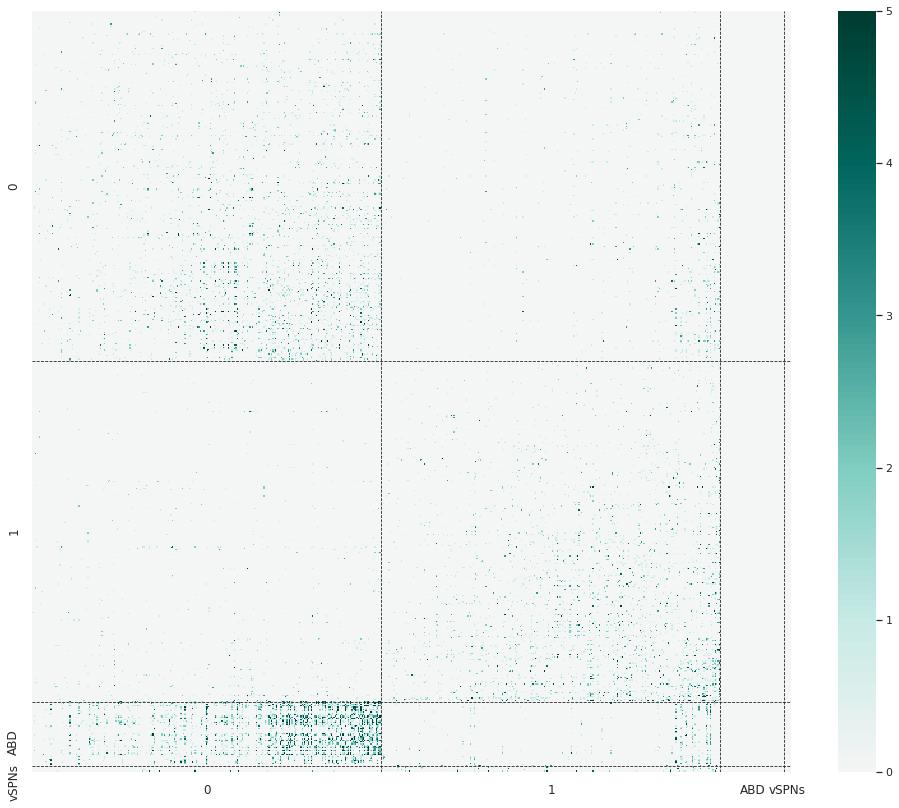

In [33]:
fig, ax = plt.subplots(figsize=(17,14))
# plt.axis('off')
sns.heatmap(np.minimum(u_adj_sub.todense()[ind_lou_type][:,ind_lou_type],5), 
            xticklabels=pretty_print_label(u.vp["Louvain+ABD+vSPNs"].a[plot_filter_mask][ind_lou_type]),
            yticklabels=pretty_print_label(u.vp["Louvain+ABD+vSPNs"].a[plot_filter_mask][ind_lou_type]),
            cmap="BrBG", center=0, ax=ax)
ax.hlines(sep_lou_type, *ax.get_xlim(), linestyles='dashed', linewidths=0.8)
ax.vlines(sep_lou_type, *ax.get_ylim(), linestyles='dashed', linewidths=0.8)

ax.tick_params(length=8, width=1.5, labelsize=12)

plt.show()

In [34]:
sep_lou_type

array([274, 540, 590, 595])

In [35]:
def norm_conn(mat, col, row):
    res = np.zeros((len(row), len(col)))
    for i, c in enumerate(col):
        for j, r in enumerate(row):
            c_prev = 0 if i == 0 else col[i-1]
            r_prev = 0 if j == 0 else row[j-1]
            c_num = c - c_prev
            r_num = r - r_prev
            res[j, i] = mat[r_prev:r][:,c_prev:c].sum()  / np.sqrt(c_num * r_num)
    return res

In [36]:
norm_conn(u_adj_sub.todense()[ind_lou_type][:,ind_lou_type], 
          [274, 540], [274, 540, 590, 595],)

array([[18.15693431,  3.91894861],
       [ 2.60769359, 18.21804511],
       [51.84242267,  4.99455342],
       [ 1.13472078,  7.21157174]])

## Comparison of Three Methods

In [40]:
u_louvain = u_louvian #typo..
label_louv = u_louvain.vp["Louvain+ABD+vSPNs"].a[lcenter_type_filter_mask]
label_spec = u_spec.vp["spec"].a[lcenter_type_filter_mask]
label_nsbm = u_SBM.vp["SBM"].a[lcenter_type_filter_mask]
gt_types = u_spec.vp["celltype"].a[lcenter_type_filter_mask]

In [41]:
type_OM = np.zeros((3, 16))
for i, labels in enumerate([label_louv, label_spec, label_nsbm]):
    ids, cnts = np.unique(gt_types[labels==0], return_counts=True)
    for cnt, nid, name in zip(cnts, ids, np.array(typenames)[ids].tolist()):
        type_OM[i, nid] = cnt

In [42]:
type_AM = np.zeros((3, 16))
for i, labels in enumerate([label_louv, label_spec, label_nsbm]):
    ids, cnts = np.unique(gt_types[labels==1], return_counts=True)
    for cnt, nid, name in zip(cnts, ids, np.array(typenames)[ids].tolist()):
        type_AM[i, nid] = cnt

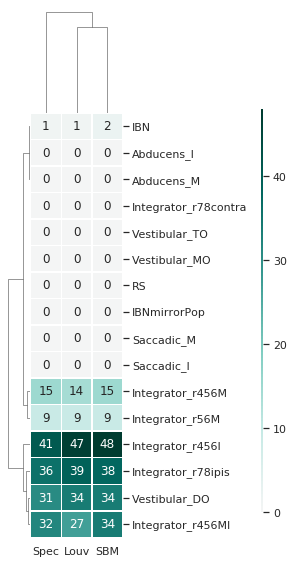

In [45]:
# plt.axis('off')
type_grid = sns.clustermap(type_OM.T, 
               center=0, 
            xticklabels=["Louv", "Spec", "SBM"],
            yticklabels=typenames,
            figsize=(3.7,8),
            row_cluster=True,
            col_cluster=True,
            cmap="BrBG",
            annot=True,
            linewidths=.5,
            cbar_pos=(1,0.1,0.01,0.7))
# plt.xlabel("nSBM Level 0 Labels")
plt.show()

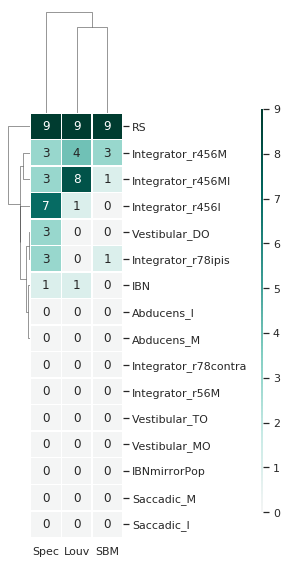

In [46]:
type_grid = sns.clustermap(type_AM.T, 
               center=0, 
            xticklabels=["Louv", "Spec", "SBM"],
            yticklabels=typenames,
            figsize=(3.7,8),
            row_cluster=True,
            col_cluster=True,
            cmap="BrBG",
            annot=True,
            linewidths=.5,
            cbar_pos=(1,0.1,0.01,0.7))
# plt.xlabel("nSBM Level 0 Labels")
plt.show()

In [47]:
lcenter_type_filter_mask.sum()

194

In [48]:
lcenter_filter_mask.sum()

540

In [50]:
from scipy.special import comb
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [55]:
labels = []
labels.append(u_louvain.vp["Louvain+ABD+vSPNs"].a[lcenter_filter_mask])
labels.append(u_spec.vp["spec"].a[lcenter_filter_mask])
labels.append(u_SBM.vp["SBM"].a[lcenter_filter_mask])

corr = np.zeros((3,3))
for i in range(3):
    for j in range(3):
#         corr[i, j] = (labels[i]==labels[j]).sum() / len(labels[i])
        corr[i, j] = rand_index_score(labels[i], labels[j])

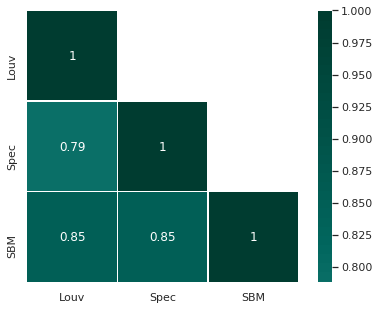

In [56]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, 
                     center=0.1,
                     cmap="BrBG",
                     annot=True, linewidths=.5,
                     xticklabels=["Louv", "Spec", "SBM"],
                     yticklabels=["Louv", "Spec", "SBM"],
                     square=True)

In [57]:
lcenter_filter_mask.sum()

540

## Save as .mat

In [139]:
from scipy.io import savemat

In [146]:
L1dict = ['OM', 'AM', 'ABD', 'vSPNs']
L1trans = np.vectorize(lambda v: L1dict[v])
plot_filter_mask = abd_filter_mask + lcenter_filter_mask + spn_filter_mask

In [147]:
u_adj_sub = gt.adjacency(u_SBM, weight=u_SBM.ep["#synapses"])[plot_filter_mask][:, plot_filter_mask]

savemat("saved/SBM_celltype_eig.mat", 
        {"SBM_celltype_eig": L1trans(u_SBM.vp["SBM+ABD+vSPNs"].a[plot_filter_mask])})
savemat("saved/SBM_cellid_eig.mat", 
        {"SBM_cellid_eig": u_SBM.vp['cellid'].a[plot_filter_mask]})
savemat("saved/SBM_connmatrix_eig.mat", 
        {"SBM_connmatrix_eig": u_adj_sub.todense()})

In [151]:
(L1trans(u_SBM.vp["SBM+ABD+vSPNs"].a[plot_filter_mask])=='AM').sum()

234

In [152]:
u_adj_sub = gt.adjacency(u_spec, weight=u_spec.ep["#synapses"])[plot_filter_mask][:, plot_filter_mask]

savemat("saved/spec_celltype_eig.mat", 
        {"spec_celltype_eig": L1trans(u_spec.vp["spec+ABD+vSPNs"].a[plot_filter_mask])})
savemat("saved/spec_cellid_eig.mat", 
        {"spec_cellid_eig": u_spec.vp['cellid'].a[plot_filter_mask]})
savemat("saved/spec_connmatrix_eig.mat", 
        {"spec_connmatrix_eig": u_adj_sub.todense()})

In [154]:
(L1trans(u_spec.vp["spec+ABD+vSPNs"].a[plot_filter_mask])=='AM').sum()

277

In [155]:
with open('saved/finalgraph_SBM_omZfish_eig.data', 'rb') as input:    
    u_omSBM = pickle.load(input)    
with open('saved/finalgraph_spectral_omZfish_eig.data', 'rb') as input:    
    u_omspec = pickle.load(input)   

In [156]:
om_mask = (np.array(u_omSBM.vp['SBM'].a==0, dtype=bool) & lcenter_filter_mask)
abd_filter_mask = np.array(u_omSBM.vp["celltype"].a)>=14
plot_filter_mask = abd_filter_mask + om_mask
L2dict = ['OM_I', 'OM_M', 'ABD_I', 'ABD_M']
L2trans = np.vectorize(lambda v: L2dict[v])

u_adj_sub = gt.adjacency(u_omSBM, weight=u_omSBM.ep["#synapses"])[plot_filter_mask][:, plot_filter_mask]

savemat("saved/SBM_OM_celltype_eig.mat", 
        {"SBM_celltype_eig": L2trans(u_omSBM.vp["omSBM+ABD_M+ABD_I"].a[plot_filter_mask])})
savemat("saved/SBM_OM_cellid_eig.mat", 
        {"SBM_cellid_eig": u_omSBM.vp['cellid'].a[plot_filter_mask]})
savemat("saved/SBM_OM_connmatrix_eig.mat", 
        {"SBM_connmatrix_eig": u_adj_sub.todense()})

In [162]:
(L2trans(u_omSBM.vp["omSBM+ABD_M+ABD_I"].a[plot_filter_mask])=='OM_I').sum()

143

In [160]:
(L2trans(u_omSBM.vp["omSBM+ABD_M+ABD_I"].a[plot_filter_mask])=='ABD_M').sum()

21

In [163]:
om_mask = (np.array(u_omspec.vp['spec'].a==0, dtype=bool) & lcenter_filter_mask)
abd_filter_mask = np.array(u_omspec.vp["celltype"].a)>=14
plot_filter_mask = abd_filter_mask + om_mask
L2dict = ['OM_M', 'OM_I', 'ABD_I', 'ABD_M']
L2trans = np.vectorize(lambda v: L2dict[v])

u_adj_sub = gt.adjacency(u_omspec, weight=u_omspec.ep["#synapses"])[plot_filter_mask][:, plot_filter_mask]

savemat("saved/spec_OM_celltype_eig.mat", 
        {"spec_celltype_eig": L2trans(u_omspec.vp["spec_l2+ABD_M+ABD_I"].a[plot_filter_mask])})
savemat("saved/spec_OM_cellid_eig.mat", 
        {"spec_cellid_eig": u_omspec.vp['cellid'].a[plot_filter_mask]})
savemat("saved/spec_OM_connmatrix_eig.mat", 
        {"spec_connmatrix_eig": u_adj_sub.todense()})

In [165]:
(L2trans(u_omspec.vp["spec_l2+ABD_M+ABD_I"].a[plot_filter_mask])=='OM_I').sum()

96

In [166]:
(L2trans(u_omspec.vp["spec_l2+ABD_M+ABD_I"].a[plot_filter_mask])=='ABD_M').sum()

21